# Import packages and aux functions

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import ast
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.naive_bayes import CategoricalNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, balanced_accuracy_score
from sklearn.model_selection import (cross_validate, cross_val_predict,cross_val_score, train_test_split, StratifiedKFold, 
                                    permutation_test_score, GridSearchCV, RandomizedSearchCV, RandomizedSearchCV)
from pprint import pprint
from joblib import dump, load
import joblib
import pickle
import matplotlib as mpl

In [2]:
def get_sorted_feat_importance(importance, feature_names):
    feature_importance = np.array(importance)
    feature_names = np.array(feature_names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_df['cum_sum_fi']=fi_df['feature_importance'].cumsum()
    return fi_df

# Content
### 1. Load Data
- Questions Data
- Feature Data
### 2. Data Preprocessing
- Hyperparametertuning: Optimize Ratio: (Nr of feature)/(Train set size)
- Downsampling the dataset with chosen features
- Visualization of the feature distributions
- Feature Encoding: Label Encoding
### 3. Baseline Model: Naive Bayes
### 4. Random Forest Model
- Hyperparametertuning with RandomSearch
- Feature importance
### 5. Evaluation 
- Permutation Test
- Cross-Validation

# Load Data

In [3]:
questions = pd.read_csv('data/questions_preprocessed.csv', sep=';', index_col=0)
descriptive_questions = [i for i in questions.index if i.startswith('dq')]
questions.loc[descriptive_questions, 'Order'] = questions.loc[descriptive_questions, 'Order'].apply(lambda row: ast.literal_eval(row))

# drop descriptive questions that reference politics 
for i in descriptive_questions:
    if any(keyword in questions.loc[i, 'text'] for keyword in ['politics', 'political', 'politician']):
            descriptive_questions.remove(i)
            
display(questions.head())

,text,option_1,option_2,option_3,option_4,N,Type,Order,Keywords
q_id,,,,,,,,,
q2,Breast implants?,more cool than pathetic,more pathetic than cool,NaN,NaN,24839,N,NaN,sex/intimacy; preference; opinion
q11,How does the idea of being slapped hard in the...,Horrified,Aroused,Nostalgic,Indifferent,28860,N,NaN,sex/intimacy
q12,Divide your age by 2. Have you had sex with a...,Yes,No,NaN,NaN,22496,O,NaN,sex/intimacy
q13,Is a girl who's slept with 100 guys a bad person?,Yes,No,NaN,NaN,32581,O,NaN,sex/intimacy
q14,Is a guy who's slept with 100 girls a bad person?,Yes,No,NaN,NaN,31127,O,NaN,sex/intimacy


In [4]:
data = pd.read_parquet('data/train.parquet')
# per question count number of times the question is answered
n_answers_per_question = data.loc[:, descriptive_questions].count(axis=0)
sorted_questions = n_answers_per_question.sort_values(ascending=False).index

question_data = questions.join(n_answers_per_question.to_frame('n_answers')) 
display(questions.loc[sorted_questions[:10]][['text']])

features_df = data[descriptive_questions]
print('Nr of rows, nr of descriptive questions', features_df.shape)

,text
dq823,Do you like watching foreign movies with subti...
dq789,Which type of wine would you prefer to drink o...
dq109,Have you smoked a cigarette in the last 6 months?
dq821,Do you enjoy intense intellectual conversations?
dq8,How frequently do you drink alcohol?
dq305,Rate your self-confidence:
dq373,How often do you keep your promises?
dq420,How often are you open with your feelings?
dq10,What's your deal with harder drugs (stuff beyo...
dq141,Are you happy with your life?


Nr of rows, nr of descriptive questions (40596, 828)


In [5]:
# Get relative frequencies
freqs = data['political_belief'].value_counts(normalize=True)*100
title = questions.loc['q212813', 'text']
freqs = freqs.rename(index = {'Liberal / Left-wing': 'Liberal/Left-wing', 'Conservative / Right-wing': 'Conservative/Right-wing'})
freqs

Liberal/Left-wing          44.383683
Other                      31.229678
Centrist                   17.504188
Conservative/Right-wing     6.882451
Name: political_belief, dtype: float64

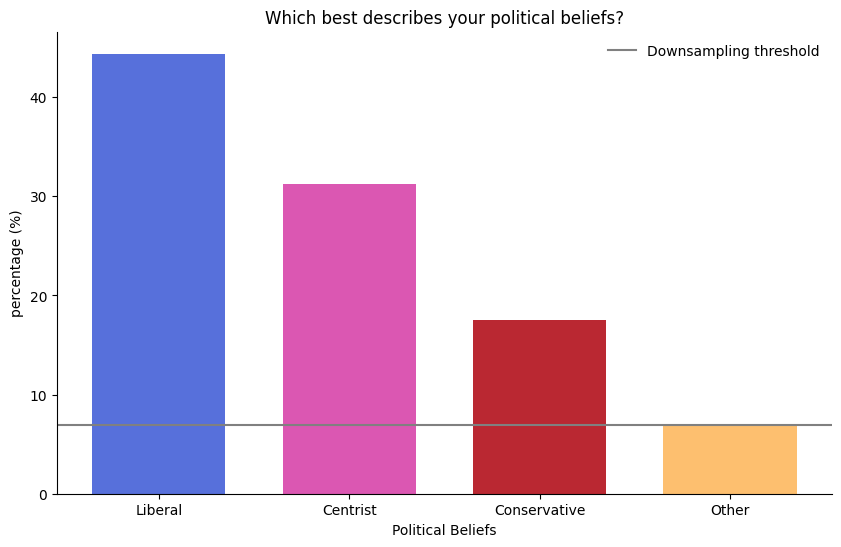

In [6]:
plt.figure(figsize=(10, 6))
ax = plt.axes()
ax.set_facecolor('white')
plt.bar(freqs.index, 
            freqs.values,
            width=0.7,
            tick_label=['Liberal', 'Centrist', 'Conservative', 'Other'],
            color=['#5770db', '#db57b2', '#ba2832', '#fdbf6f'])
plt.title(title)
plt.ylabel('percentage (%)')
plt.xlabel("Political Beliefs")
plt.tick_params(bottom=True, left=True)
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_visible(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.spines['left'].set_color('black')
ax.axhline(y=6.882451, color='gray', linestyle='-', label='Downsampling threshold')
plt.legend(frameon=False) 
plt.savefig("data/images/Political_Belief_Distribution.png")
plt.show()

In [ ]:
df_trn, df_val = train_test_split(data[descriptive_questions + ['political_belief', 'gender', 'd_age']], test_size=0.1, random_state=1)
df_val = df_val[descriptive_questions+['political_belief']]

# Data preprocessing
To keep the train set reasonably big, we compute, how many questions we can include, s.t. that the nr. of subjects who answered these questions is at least 8.000. 


In [ ]:
K=200
subset_size_topk = [features_df.loc[:, sorted_questions[:k]].dropna().shape[0] for k in range(1, K)]

In [ ]:
# biggest k with >8.000 to 25.000 subjects who answered ALL k questions
min_train_size = np.arange(8, 25)*1000
n_most_answered = [next(x[0] for x in enumerate(subset_size_topk) if x[1] < min_set_size) for min_set_size in min_train_size]
n_most_answered

In [ ]:
print(f'Shape of validation set before: {df_val.shape}')
top_questions = sorted_questions[:np.max(n_most_answered)].to_list()
df_val_topq = df_val[top_questions+['political_belief']].dropna() 
print(f'Shape of validation set after selecting the top {np.max(n_most_answered)} questions: {df_val_topq.shape}')

X_val_topq = df_val_topq[top_questions]
y_val = df_val_topq[['political_belief']]

In [ ]:
for n, min_size in zip(n_most_answered[:2], min_train_size):
    sns.set_style("white")
    sns.set_style("ticks")
    sns.set
    g = sns.lineplot(x = range(1,K), y = subset_size_topk, linewidth=1)
    g.axhline(y=min_size, color='red', linewidth=0.5)
    g.axvline(x=n, color='red', linewidth=0.5)

    plt.xlim(0, 200)
    plt.ylim(0)
    sns.despine()
    #plt.ylim(0,len(features_df))
    g.set(xlabel ="Cardinality of set of most answered questions", ylabel = "Nr of subjects who answered the questions")
    #title ='Nr of subjects who answered the same k most anwered questions '
    #plt.figtext(0.5, -0.1, 'Grouping most answered questions into a set, comparing the number of questions in the set to the number of subjects who answered all questions in the set', wrap=True, horizontalalignment='center', fontsize=12)
    plt.title(f'minimum train size before downsampling: {min_size}')
    plt.show()

## HPO: Optimize Ratio: (Nr of feature)/(Train set size)

In [ ]:
val_scores = []

for n in n_most_answered:
    top_questions = sorted_questions[:n].to_list()
    filter_by = top_questions + ['political_belief']
    downsampled_df = df_trn[filter_by].dropna()
    n_conservative = downsampled_df.groupby('political_belief').count().iloc[1, 0]
    downsampled_df = downsampled_df.groupby('political_belief', group_keys=False).apply(lambda x: x.sample(n=n_conservative, random_state=1))


    # split into features and target
    features_df_downsampled = downsampled_df[top_questions]
    target = downsampled_df.loc[features_df_downsampled.index][['political_belief']]

    # encode train and validation set
    feature_encoder = OrdinalEncoder()
    target_encoder = LabelEncoder()
    # train set
    X_train_encoded = feature_encoder.fit_transform(features_df_downsampled)
    y_train_encoded = target_encoder.fit_transform(target.values.ravel())
    # val set
    X_val_encoded = feature_encoder.transform(X_val_topq[top_questions])
    y_val_encoded = target_encoder.transform(y_val.values.ravel())

    # Naive Bayes Hyper parameter Tuning
    nb = CategoricalNB(fit_prior=False).fit(X_train_encoded, y_train_encoded)
    preds = nb.predict(X_val_encoded)
    val_scores.append(balanced_accuracy_score(y_val_encoded, preds))

best_nr_of_questions = n_most_answered[np.argmax(val_scores)]
print(f'Best balanced accuracy on the validation set obtained with {best_nr_of_questions} number of answered questions')

In [ ]:
sns.set_style("white")
sns.set_style("ticks")
g = sns.lineplot(x = n_most_answered, y = val_scores, linewidth=1)
g.axhline(y=np.max(val_scores), color='red', linewidth=0.5)
g.axvline(x=best_nr_of_questions, color='red', linewidth=0.5)
sns.despine()
g.set(ylabel ='Balanced Accuracy Score', xlabel ='Nr of questions as features', title='Evaluation on validation set')
plt.show()

## Downsampling the dataset with chosen features

In [ ]:
best_nr_of_questions = 62

In [ ]:
top_questions = sorted_questions[:best_nr_of_questions].to_list()
filter_by = top_questions + ['political_belief', 'd_age', 'gender']
downsampled_df = data[filter_by].dropna()
n_conservative = downsampled_df.groupby('political_belief').count().iloc[1, 0]
downsampled_df = downsampled_df.groupby('political_belief', group_keys=False).apply(lambda x: x.sample(n=n_conservative, random_state=1))
display(downsampled_df.head())

## Visualize of the feature distribution

In [ ]:
def plot_question_density(question: str, data: pd.DataFrame, questions: pd.DataFrame, save:bool=False, x_lim=None, legend:bool=True, font_scale=1.5):
    x,y = question, 'political_belief'
    df1 = ((data.groupby(x)[y].value_counts())/len(data)).rename('percentage').reset_index()
    df1['percentage'] = df1['percentage']*100
    title = questions.loc[question, 'text']
    plt.figure(figsize=(8,20))
    sns.set(font_scale=font_scale, font='Times New Roman')
    sns.set_style("white")
    sns.set_style("ticks")
    if not x_lim:
        x_lim = np.max(df1['percentage'])+2
    g = sns.catplot(x='percentage',y=x,hue=y, kind='bar', data=df1, 
                hue_order= ['Liberal / Left-wing', 'Centrist', 'Conservative / Right-wing', 'Other'], 
                palette={'Liberal / Left-wing': '#5770db', 'Centrist': '#db57b2', 'Conservative / Right-wing': '#ba2832', 'Other': '#fdbf6f'},
                order = questions.loc[question, 'Order'],
                legend=False,
                height = 10, aspect = 3,
    
                ).set(xlabel ="percentage (%)", ylabel = "", title=title) 
    #plt.xlim(0,x_lim)
    plt.xticks(np.arange(0, x_lim+1, 2))     
    if legend:
        plt.legend(title="", bbox_to_anchor=(1, 1), loc='upper left', fontsize=40) 
    
    if save:
        plt.savefig(f'data/images/{question}.png',bbox_inches='tight')
    sns.despine(right=True, top=True)
    plt.show()   

In [ ]:
top2_important = ['dq586', 'dq9']
plot_question_density('dq586', downsampled_df, questions, x_lim=16, save=True, legend=True, font_scale=4)
plot_question_density('dq9', downsampled_df, questions, x_lim=16, save=True, font_scale=4)

In [ ]:
# split into features and target
features_df_topq = downsampled_df[top_questions]
target = downsampled_df.loc[features_df_topq.index][['political_belief']]

In [ ]:
feature_encoder = OrdinalEncoder()
target_encoder = LabelEncoder()
X_train_encoded = feature_encoder.fit_transform(features_df_topq)
y_train_encoded = target_encoder.fit_transform(target.values.ravel())

In [ ]:
pickle.dump(feature_encoder, open('models/feature_encoder.pkl', 'wb'))
pickle.dump(target_encoder, open('models/target_encoder.pkl', 'wb'))

In [ ]:
print('Size of final downsampled trainset')
X_train_encoded.shape

# Baseline Model: Naive Bayes

In [ ]:
nb = CategoricalNB(fit_prior=False).fit(X_train_encoded, y_train_encoded)
scores = cross_val_score(nb, X_train_encoded, y_train_encoded, cv=3, scoring='balanced_accuracy')
print(f"balanced accuracy with mean: {scores.mean()} a standard deviation of {scores.std()}")

In [ ]:
# Save model
joblib.dump(nb, 'models/nb_downsampled_trn_set.joblib') 

# Random Forest Classifier
## Hyperparameter Tuning
HPT using Random Search with downsampled K-fold crossvalidation \
Chosen scoring metrics: balanced accuracy (average of recall obtained on each class)

In [ ]:
# Choose parameter distributions
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1500, num = 10)]
max_depth = [int(x) for x in np.linspace(10, 110, num = 15)]
min_samples_split = [8, 10, 12, 14, 15, 16, 18]
min_samples_leaf = [1, 2, 3, 4]
bootstrap = [True, False]
param_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
              'bootstrap': bootstrap,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               }
pprint(param_grid)

In [ ]:
rf = RandomForestClassifier(class_weight='balanced', random_state=1)
rf_random = RandomizedSearchCV(estimator = rf,
                             param_distributions = param_grid, 
                             n_iter = 500, 
                             cv = 3, 
                             verbose=2, 
                             random_state=42, 
                             n_jobs = -1, 
                             scoring='balanced_accuracy')
rf_random.fit(X_train_encoded, y_train_encoded)

In [ ]:
print('Results of parameter tuning with random search:')
best_random_params = rf_random.best_params_
pprint(best_random_params)

In [ ]:
rf_tuned = rf_random.best_estimator_
scores = cross_val_score(rf_tuned, X_train_encoded, y_train_encoded, cv=5, scoring='balanced_accuracy')
print(f"balanced accuracy with mean: {scores.mean()} a standard deviation of {scores.std()}")

In [ ]:
# save model
joblib.dump(rf_tuned, 'models/rf_downsampled_trn_set.joblib') 

## Visualize feature importance

In [ ]:
fi_df = get_sorted_feat_importance(rf_tuned.feature_importances_, features_df_topq.columns)
print('Top 20 Features sorted by their gini impotance scores ')
for i, row in fi_df[:20].iterrows():
    print(f"Feature {row['feature_names']}: {questions.loc[row['feature_names']].text}: {row['feature_importance']}")

In [ ]:
#Define size of bar plot
plt.figure(figsize=(10,8))
sns.set_style("white")
sns.set_style("ticks")
#Plot Searborn bar chart
g = sns.barplot(y=fi_df['feature_importance'].values, x=np.arange(len(fi_df.index)), color='gray', alpha=0.7)
sns.despine()

g.set_xticklabels(fi_df['feature_names'])
#Add chart labels
g.set_title('Random forest: Sorted feature imporatance (gini)')
g.set(ylabel ='feature impotance', xlabel ='question_ids')
plt.show()

In [ ]:
# first top k question, s.t. Cumultative sum of feature importance is >=.95
cum_sum_top_k = next(x[0] for x in enumerate(fi_df.cum_sum_fi) if x[1] >=0.95)

sns.set_style("white")
sns.set_style("ticks")
g = sns.lineplot(x = np.arange(len(fi_df)), y = fi_df['cum_sum_fi'])
g.axhline(y=fi_df['cum_sum_fi'].iloc[cum_sum_top_k], color='red', linewidth=0.5)
g.axvline(x=cum_sum_top_k, color='red', linewidth=0.5)
sns.despine()
plt.ylim(0)
plt.xlim(0)
g.set(xlabel='number of included features', ylabel='cum. score', title='Cumultative sum of feature importance', xticks=np.arange(len(fi_df), step=2))
plt.show()

# Evaluation

## Permutation Test


Reference:

[1]
Ojala and Garriga. Permutation Tests for Studying Classifier Performance. The Journal of Machine Learning Research (2010) vol. 11

In [ ]:
## Permutation Test

rf_tuned = joblib.load(open('models/rf_downsampled_trn_set.joblib', 'rb'))

rng = np.random.RandomState(seed=0)
# Use same number of samples and features as in the original data 
X_rand = np.random.permutation(X_train_encoded)

clf = rf_tuned
cv = StratifiedKFold(2, shuffle=True, random_state=1)

score_data, perm_scores_data, pvalue_data = permutation_test_score(
    clf, X_train_encoded, y_train_encoded, scoring="balanced_accuracy", cv=cv, n_permutations=1000, n_jobs=-3
)

score_rand, perm_scores_rand, pvalue_rand = permutation_test_score(
    clf, X_rand, y_train_encoded, scoring="balanced_accuracy", cv=cv, n_permutations=1000, n_jobs = -3
)

In [ ]:
plt.figure(figsize=(7,5))

sns.set(font_scale=1)
sns.set_style("white")
sns.set_style("ticks")

g = sns.histplot(perm_scores_data, binwidth=0.009, common_norm=True, label='scores on permuted data')
plt.vlines(score_data, ymin=0, ymax=370, ls="--", color="r", label='score on original data')

g.legend(title=f'p-value: {pvalue_data:.3f}',frameon=False)
g.set_xlim(0,1)
g.set_xlabel('Balanced accuracy score')
g.set_xticks([0, perm_scores_data.mean(), score_data.round(4), 0.5, 0.75, 1])
g.set_xticklabels([0, perm_scores_data.mean().round(2), score_data.round(4), 0.5, 0.75, 1])
sns.despine()


plt.figure(figsize=(7,5))
sns.set_style("white")
sns.set_style("ticks")

g = sns.histplot(perm_scores_rand, binwidth=0.009, common_norm=True, label='scores on permuted data')
plt.vlines(score_rand, ymin=0, ymax=360, ls="--", color="r", label='score on random data')

g.legend(title=f'p-value: {pvalue_rand:.2f}',frameon=False)
g.set_xlim(0,1)
g.set_xlabel('Balanced accuracy score')
g.set_xticks([0, perm_scores_rand.mean(), score_rand.round(2), 0.5, 0.75, 1])
g.set_xticklabels([0, perm_scores_rand.mean().round(2), score_rand.round(2), 0.5, 0.75, 1])
sns.despine()